# Test sampling algorithms

In [1]:
import os
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import scipy.interpolate
import ultraplot as plt
from tqdm import tqdm

import ment

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

Create a particle distribution.

In [3]:
# Settings
ndim = 4
size = 1_000_000
n_modes = 5
seed = 1241

# Create gaussian particle distribution
rng = np.random.default_rng(seed)
mean = np.zeros(ndim)
cov = np.identity(ndim)
for i in range(ndim):
    for j in range(i):
        cov[i, j] = cov[j, i] = rng.uniform(-0.4, 0.4)
x = rng.multivariate_normal(mean, cov, size=size)

# Add gaussian blobs
for _ in range(n_modes):
    scale = rng.uniform(0.8, 1.5, size=ndim)
    loc = rng.uniform(-5.0, 3.0, size=ndim)
    x = np.vstack([x, rng.normal(loc=loc, scale=scale, size=(size // n_modes, ndim))])
x = x - np.mean(x, axis=0)

rng.shuffle(x)

x_true = np.copy(x)

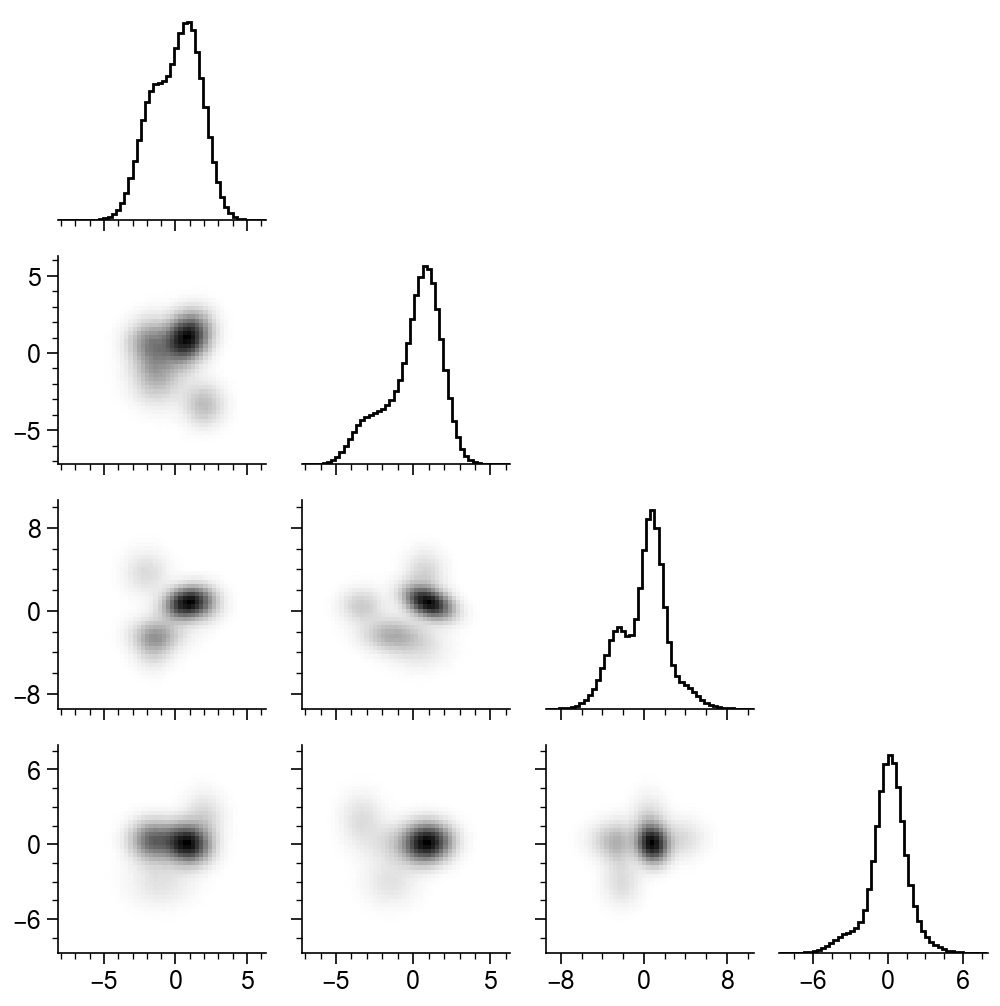

In [4]:
limits = ps.limits(x_true)

grid = psv.CornerGrid(ndim, corner=True, figwidth=(1.25 * ndim))
grid.plot(
    x_true,
    bins=50,
    limits=limits,
    cmap="mono",
)
plt.show()

Compute ground-truth histogram.

In [5]:
n_bins = 25
values, edges = np.histogramdd(x_true, bins=n_bins, range=limits, density=True)
hist = ps.Histogram(values=values, edges=edges)
print("hist.shape =", hist.shape)

hist.shape = (25, 25, 25, 25)


Interpolate to obtain a smooth density function.

In [6]:
prob_func = scipy.interpolate.RegularGridInterpolator(
    hist.coords,
    hist.values,
    method="linear",
    bounds_error=False,
    fill_value=0.0,
)

## Grid Sampling (GS)

In [7]:
samp_grid_res = 15  # limit ~ 15
grid_shape = [samp_grid_res] * ndim
grid_limits = limits

sampler = ment.samp.GridSampler(
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    noise=0.0,
)

start_time = time.time()
x_samp = sampler(prob_func, size)

print("time:", time.time() - start_time)

time: 0.18027973175048828


Plot a samples over histogram projections.

In [8]:
def plot_corner_samp(x_samp: np.ndarray):
    limits = ps.limits(x_true, rms=2.5)

    grid = psv.CornerGrid(ndim, corner=True, figwidth=(1.25 * ndim))
    grid.set_limits(limits)
    grid.plot_hist(hist, cmap="mono")
    grid.plot(x_samp[:, :], kind="hist", alpha=0.0, diag_kws=dict(color="red"))
    grid.plot(
        x_samp[:1000, :],
        diag=False,
        kind="scatter",
        color="red",
        s=0.25,
    )
    return grid

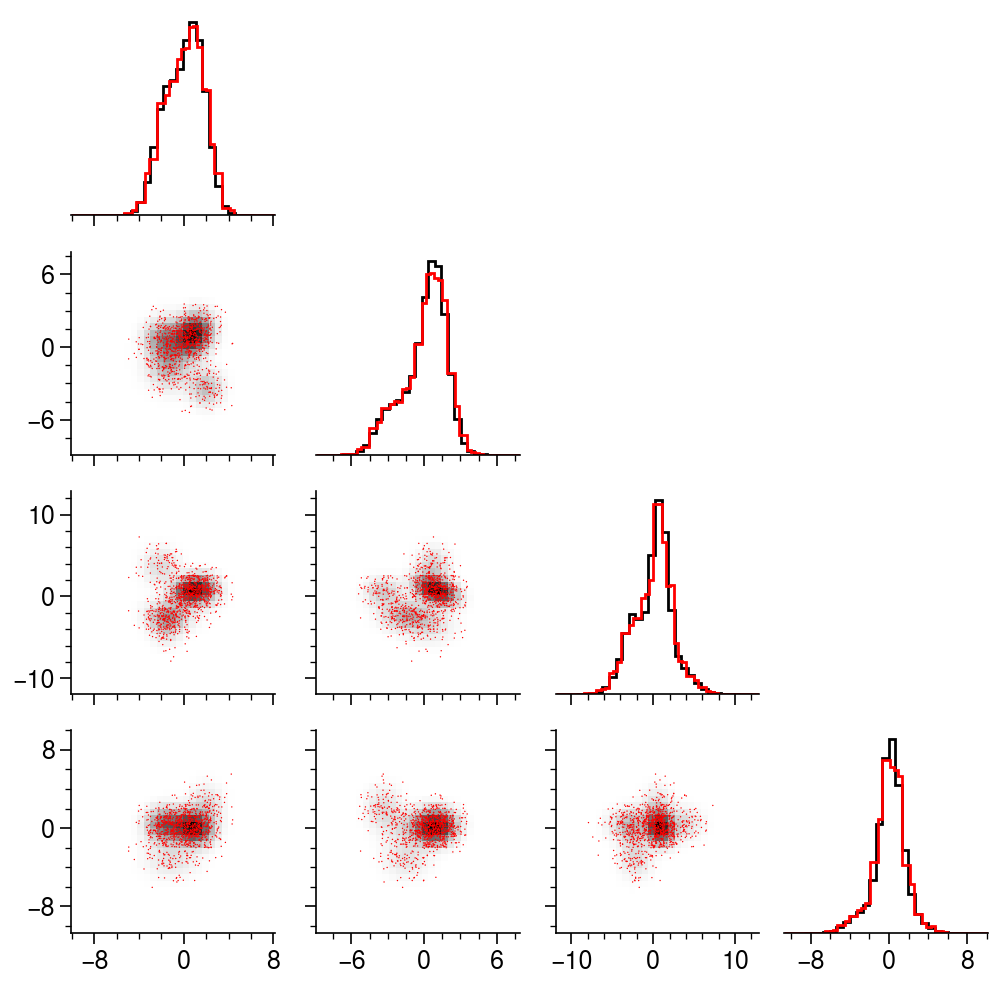

In [9]:
grid = plot_corner_samp(x_samp)

## Slice Grid Sampling (GS)

In [10]:
samp_res = 20
int_res = 10

ndim_proj = 2
ndim_samp = ndim_int = ndim - ndim_proj

grid_shape = [samp_res] * ndim
grid_limits = limits
int_size = int(int_res**ndim_int)

sampler = ment.samp.SliceGridSampler(
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    proj_dim=ndim_proj,
    int_size=int_size,
    int_method="grid",
    int_batches=1,
    noise=0.0,
    verbose=True,
)

start_time = time.time()
x_samp = sampler(prob_func, size)
print("time:", time.time() - start_time)

Projecting


  0%|                                                                                                                                                                             | 0/400 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 9832.17it/s]

Sampling


0it [00:00, ?it/s]

288it [00:00, 2877.41it/s]

400it [00:00, 3311.51it/s]

time:

 0.8110141754150391


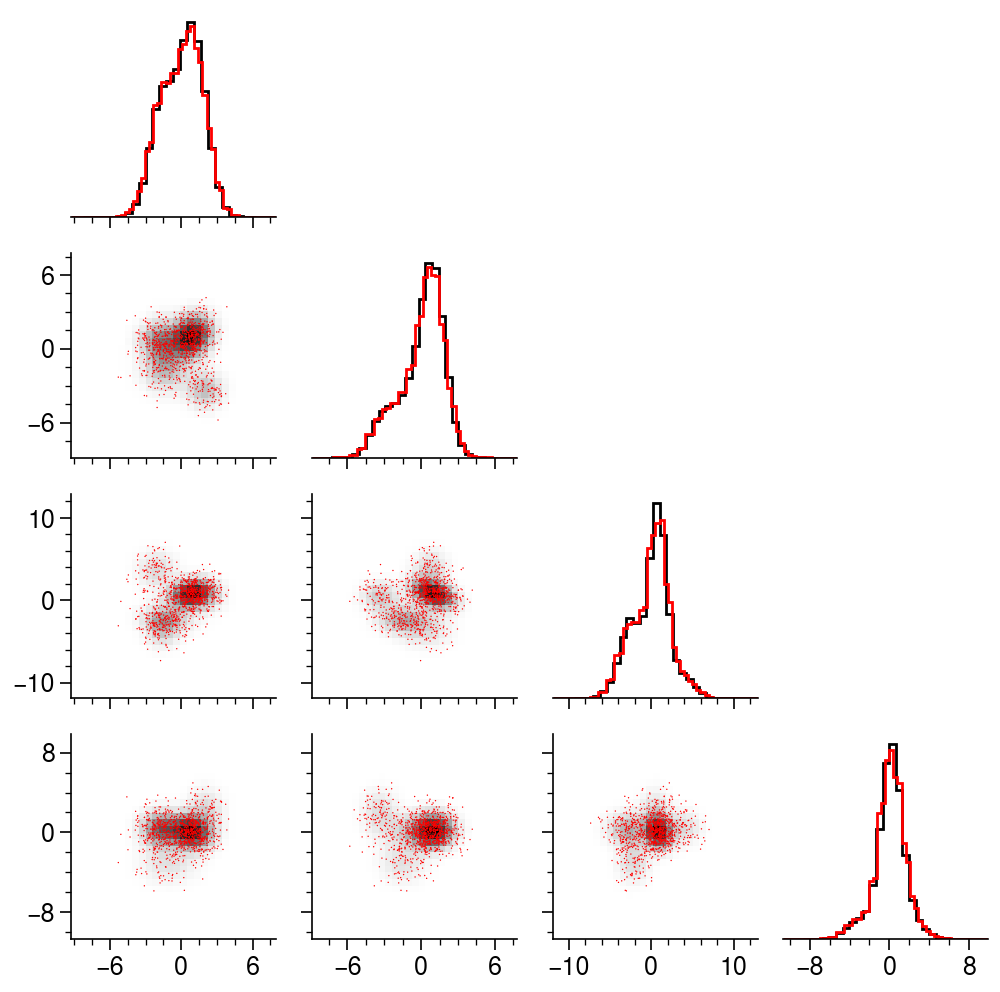

In [11]:
grid = plot_corner_samp(x_samp)

## Metropolis-Hastings

In [12]:
sampler = ment.samp.MetropolisHastingsSampler(
    ndim=ndim,
    proposal_cov=np.eye(ndim),
    start=None,
    chains=1,
    burnin=1_000,
    shuffle=True,
    verbose=True,
)
x_samp = sampler(prob_func, size=100_000)

  0%|                                                                                                                                                                          | 0/100999 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                          | 1179/100999 [00:00<00:08, 11786.33it/s]

  2%|███▊                                                                                                                                                        | 2433/100999 [00:00<00:08, 12229.08it/s]

  4%|█████▋                                                                                                                                                      | 3656/100999 [00:00<00:08, 12161.71it/s]

  5%|███████▌                                                                                                                                                    | 4889/100999 [00:00<00:07, 12225.81it/s]

  6%|█████████▍                                                                                                                                                  | 6125/100999 [00:00<00:07, 12272.98it/s]

  7%|███████████▍                                                                                                                                                | 7375/100999 [00:00<00:07, 12347.25it/s]

  9%|█████████████▎                                                                                                                                              | 8621/100999 [00:00<00:07, 12381.27it/s]

 10%|███████████████▏                                                                                                                                            | 9860/100999 [00:00<00:07, 12369.41it/s]

 11%|█████████████████                                                                                                                                          | 11097/100999 [00:00<00:07, 12267.70it/s]

 12%|██████████████████▉                                                                                                                                        | 12324/100999 [00:01<00:07, 12080.63it/s]

 13%|████████████████████▊                                                                                                                                      | 13533/100999 [00:01<00:07, 11910.98it/s]

 15%|██████████████████████▌                                                                                                                                    | 14725/100999 [00:01<00:07, 11619.42it/s]

 16%|████████████████████████▍                                                                                                                                  | 15889/100999 [00:01<00:07, 11392.45it/s]

 17%|██████████████████████████▏                                                                                                                                | 17100/100999 [00:01<00:07, 11600.50it/s]

 18%|████████████████████████████                                                                                                                               | 18317/100999 [00:01<00:07, 11767.07it/s]

 19%|██████████████████████████████                                                                                                                             | 19586/100999 [00:01<00:06, 12038.63it/s]

 21%|███████████████████████████████▉                                                                                                                           | 20792/100999 [00:01<00:06, 12025.34it/s]

 22%|█████████████████████████████████▊                                                                                                                         | 22014/100999 [00:01<00:06, 12081.73it/s]

 23%|███████████████████████████████████▋                                                                                                                       | 23224/100999 [00:01<00:06, 12032.00it/s]

 24%|█████████████████████████████████████▌                                                                                                                     | 24441/100999 [00:02<00:06, 12070.29it/s]

 25%|███████████████████████████████████████▍                                                                                                                   | 25688/100999 [00:02<00:06, 12187.33it/s]

 27%|█████████████████████████████████████████▎                                                                                                                 | 26953/100999 [00:02<00:06, 12323.31it/s]

 28%|███████████████████████████████████████████▎                                                                                                               | 28186/100999 [00:02<00:06, 11692.38it/s]

 29%|█████████████████████████████████████████████▏                                                                                                             | 29429/100999 [00:02<00:06, 11904.77it/s]

 30%|███████████████████████████████████████████████                                                                                                            | 30641/100999 [00:02<00:05, 11966.98it/s]

 32%|████████████████████████████████████████████████▉                                                                                                          | 31858/100999 [00:02<00:05, 12026.43it/s]

 33%|██████████████████████████████████████████████████▊                                                                                                        | 33140/100999 [00:02<00:05, 12259.42it/s]

 34%|████████████████████████████████████████████████████▋                                                                                                      | 34369/100999 [00:02<00:05, 12132.00it/s]

 35%|██████████████████████████████████████████████████████▋                                                                                                    | 35608/100999 [00:02<00:05, 12207.80it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                  | 36831/100999 [00:03<00:05, 11908.99it/s]

 38%|██████████████████████████████████████████████████████████▎                                                                                                | 38025/100999 [00:03<00:05, 11888.21it/s]

 39%|████████████████████████████████████████████████████████████▏                                                                                              | 39230/100999 [00:03<00:05, 11933.71it/s]

 40%|██████████████████████████████████████████████████████████████                                                                                             | 40469/100999 [00:03<00:05, 12066.16it/s]

 41%|████████████████████████████████████████████████████████████████                                                                                           | 41708/100999 [00:03<00:04, 12160.30it/s]

 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 42925/100999 [00:03<00:04, 12089.79it/s]

 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 44135/100999 [00:03<00:04, 11973.88it/s]

 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 45350/100999 [00:03<00:04, 12022.52it/s]

 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 46553/100999 [00:03<00:04, 11989.72it/s]

 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 47759/100999 [00:03<00:04, 12008.37it/s]

 48%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 48980/100999 [00:04<00:04, 12066.26it/s]

 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 50187/100999 [00:04<00:04, 11841.89it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                            | 51373/100999 [00:04<00:04, 11512.18it/s]

 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 52527/100999 [00:04<00:04, 11447.90it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 53728/100999 [00:04<00:04, 11609.47it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 54948/100999 [00:04<00:03, 11780.75it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 56144/100999 [00:04<00:03, 11831.15it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 57329/100999 [00:04<00:03, 11751.30it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 58505/100999 [00:04<00:03, 11724.47it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 59678/100999 [00:04<00:03, 11652.26it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 60895/100999 [00:05<00:03, 11803.36it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 62096/100999 [00:05<00:03, 11864.35it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 63301/100999 [00:05<00:03, 11918.80it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 64494/100999 [00:05<00:03, 11907.17it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 65696/100999 [00:05<00:02, 11940.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 66891/100999 [00:05<00:02, 11896.72it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 68081/100999 [00:05<00:02, 11779.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 69288/100999 [00:05<00:02, 11864.32it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 70490/100999 [00:05<00:02, 11910.45it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 71682/100999 [00:06<00:02, 11817.57it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 72865/100999 [00:06<00:02, 11750.47it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 74041/100999 [00:06<00:02, 11229.50it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 75169/100999 [00:06<00:02, 11044.00it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 76313/100999 [00:06<00:02, 11156.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 77495/100999 [00:06<00:02, 11347.77it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 78711/100999 [00:06<00:01, 11586.05it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 79898/100999 [00:06<00:01, 11669.92it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 81069/100999 [00:06<00:01, 11681.68it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 82239/100999 [00:06<00:01, 11636.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 83419/100999 [00:07<00:01, 11682.81it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 84630/100999 [00:07<00:01, 11809.68it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 85831/100999 [00:07<00:01, 11867.77it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 87019/100999 [00:07<00:01, 11724.96it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 88212/100999 [00:07<00:01, 11785.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 89392/100999 [00:07<00:01, 11400.74it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 90535/100999 [00:07<00:00, 11215.13it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 91719/100999 [00:07<00:00, 11394.80it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 92888/100999 [00:07<00:00, 11479.76it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 94100/100999 [00:07<00:00, 11667.15it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 95286/100999 [00:08<00:00, 11721.74it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 96513/100999 [00:08<00:00, 11882.03it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 97703/100999 [00:08<00:00, 11635.06it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 98869/100999 [00:08<00:00, 11627.99it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 100077/100999 [00:08<00:00, 11761.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100999/100999 [00:08<00:00, 11835.05it/s]

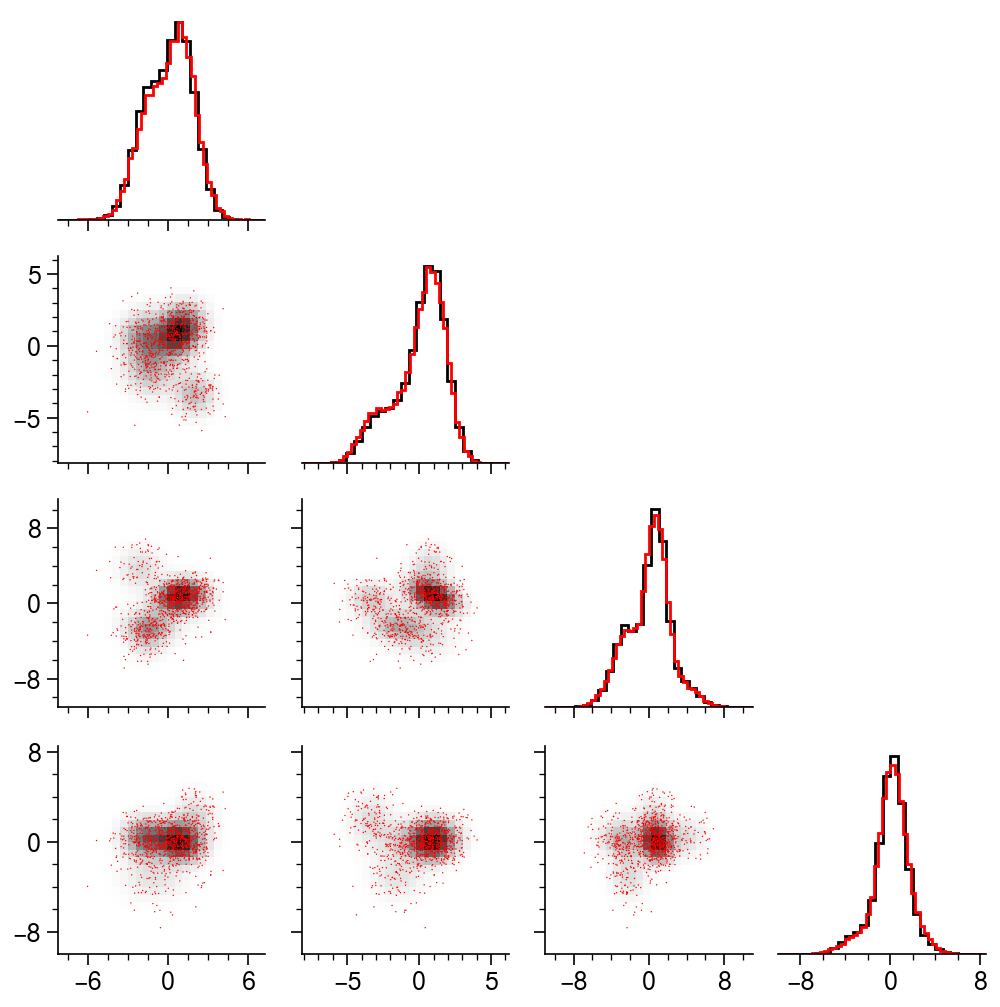

In [13]:
grid = plot_corner_samp(x_samp)

In [14]:
sampler = ment.samp.MetropolisHastingsSampler(
    ndim=ndim,
    proposal_cov=np.eye(ndim),
    start=None,
    chains=10,
    burnin=1_000,
    shuffle=True,
    verbose=True,
)
x_samp = sampler(prob_func, size=100_000)

  0%|                                                                                                                                                                           | 0/10999 [00:00<?, ?it/s]

 10%|████████████████▏                                                                                                                                            | 1131/10999 [00:00<00:00, 11300.39it/s]

 21%|████████████████████████████████▎                                                                                                                            | 2262/10999 [00:00<00:00, 10529.24it/s]

 30%|███████████████████████████████████████████████▍                                                                                                             | 3319/10999 [00:00<00:00, 10416.73it/s]

 40%|██████████████████████████████████████████████████████████████▎                                                                                              | 4363/10999 [00:00<00:00, 10367.12it/s]

 49%|█████████████████████████████████████████████████████████████████████████████                                                                                | 5401/10999 [00:00<00:00, 10351.07it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6547/10999 [00:00<00:00, 10721.62it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 7621/10999 [00:00<00:00, 10676.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8690/10999 [00:00<00:00, 10651.43it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 9803/10999 [00:00<00:00, 10795.99it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 10921/10999 [00:01<00:00, 10913.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10999/10999 [00:01<00:00, 10699.95it/s]

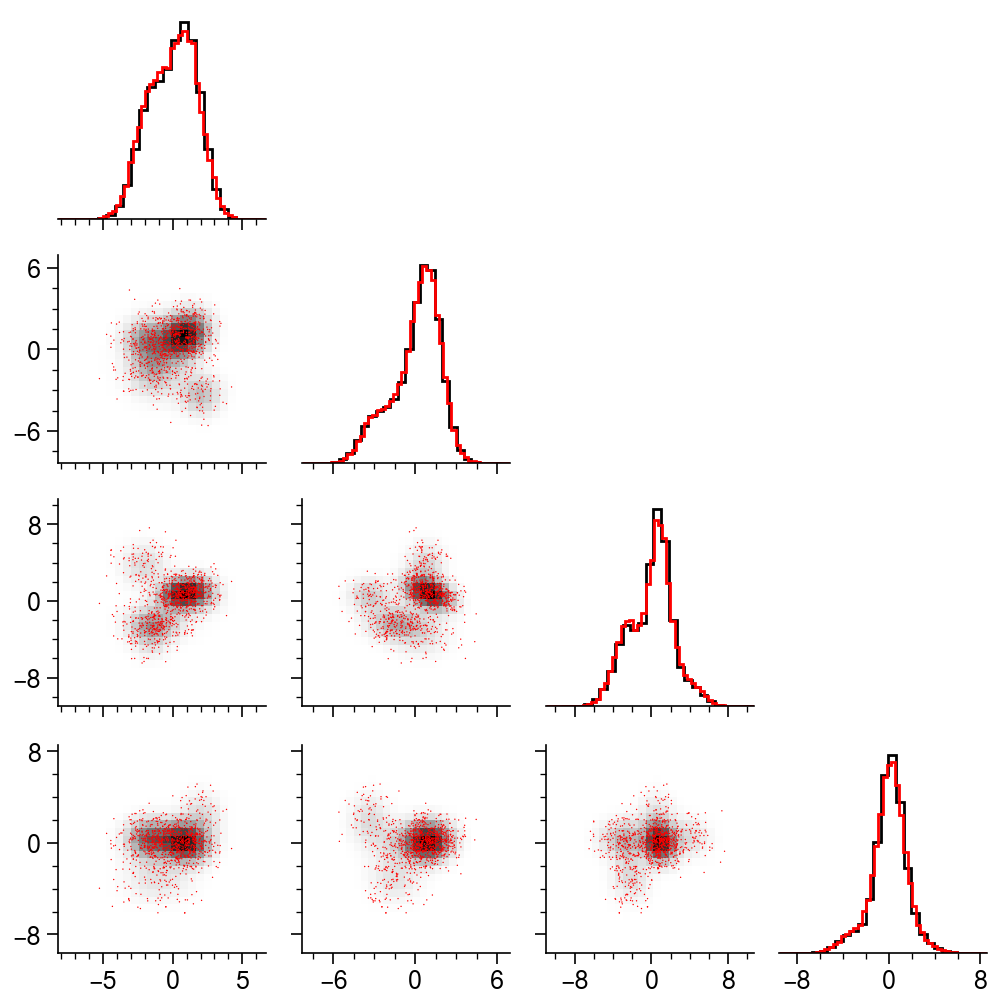

In [15]:
grid = plot_corner_samp(x_samp)